# Part 3: Forecasting with a Prophet 📉

One piece of recent open software is facebook's `prophet`. This uses a model which is similar to a **generalised additive model** (GAM), a class of additive (linear) models with potentially non-linear components. 

The model is easily interpreted (as a sum of components) and simple to fit (parameters have a strightforward interpretation). But if the hypothesis of the parametric model are not respected, the fitted model may seriously underfit.

As you are beginning to see time series forecasting can sometimes be as much an art as a science, and we know it takes quite some practice to become a good artist. The authors of the software had this in mind when they wrote it. One of their aims is to provide software which can be used easily by those who have a little timeseries knowledge. Let's see how this goes...

**Resources**

- https://peerj.com/preprints/3190/
- https://www.youtube.com/watch?v=2XFro0nIHQM&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s&index=10
- https://www.youtube.com/watch?v=95-HMzxsghY
- https://www.youtube.com/watch?v=pOYAXv15r3A 

**Required librairies**
- [ ] prophet
- [ ] numpy
- [ ] pandas
- [ ] matplotlib
- [ ] seaborn
- [ ] pmdarima

To install prophet I advise you to install a completely clean virtual environment with conda (you will find the instructions to do this [here](https://docs.conda.io/projects/conda/en/4.6.1/user-guide/tasks/manage-environments.html)), with numpy, pandas, matplotlib, seaborn and pmdarima.

Then you can install prophet with: `conda install conda-forge::prophet`


In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from prophet import Prophet
pd.plotting.register_matplotlib_converters()

# Example 1 - Airline data

Let's setup the data as we had done in the previous parts.

In [2]:
from pmdarima.datasets import load_airpassengers

def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

# There's no datetimeindex from the bundled dataset. So let's add one.
airline.index= pd.date_range(START_DATE, 
                             periods=len(airline), 
                             freq='MS')

airline_adj = airline / airline.index.days_in_month # Remove spurious features due to variations of months duration
train, test = ts_train_test_split(airline_adj, '1960-01-01') # Split the dataset into train and test set
train_log, test_log = np.log(train), np.log(test) # Apply the log transformation

## Forecasting with prophet

Fitting a basic model and making predictions is very simple with `prophet`. You simply need to create a Prophet object, and then call its `fit` method on the training data.

The training data is expected in this data frame format

In [3]:
train_df = pd.DataFrame(train).reset_index().rename(columns = {0:'y','index':'ds'})
train_df.tail()

,ds,y
127,1959-08-01,18.032258
128,1959-09-01,15.433333
129,1959-10-01,13.129032
130,1959-11-01,12.066667
131,1959-12-01,13.064516


Fit model...

In [4]:
model = Prophet()
model.fit(train_df)

10:36:34 - cmdstanpy - INFO - Chain [1] start processing
10:36:34 - cmdstanpy - INFO - Chain [1] done processing


Make predictions...

In [5]:
future = model.make_future_dataframe(periods=12, 
                                     freq='MS', 
                                     include_history=True) 

# Create a dataframe with the prediction datetimes we want
future.head()

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01


In [6]:
forecast = model.predict(future)
y_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')

Plot predictions...

<Axes: xlabel='ds', ylabel='y'>

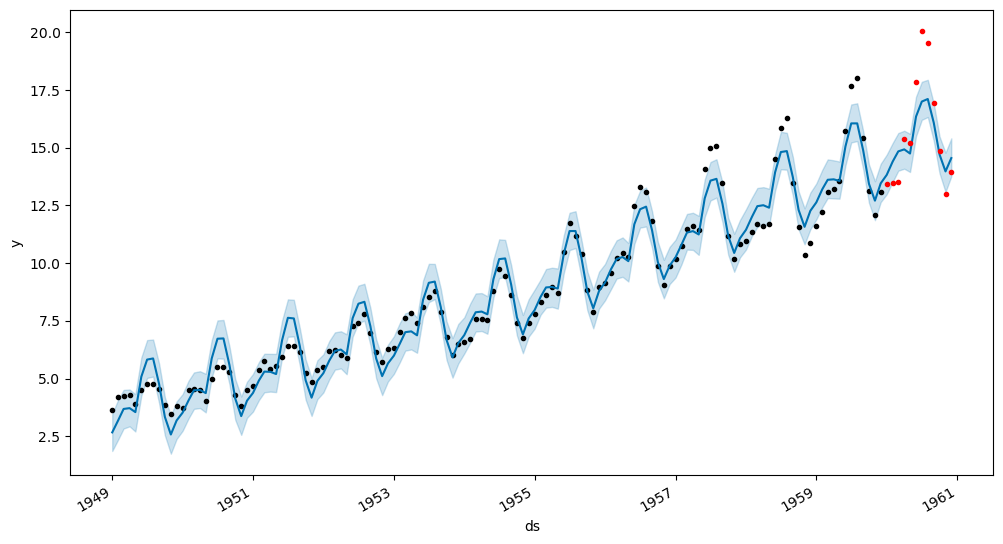

In [7]:
fig = model.plot(forecast)
test.plot(style='.r')

Evaluating this baseline model error on test set...

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
mean_absolute_percentage_error(test.values , 
                               forecast['yhat'][-12:])

6.616329767294138

We see the Prophet at least beats the naive model that we defined in the last notebook (from the unlogged data). Not too bad, given the small number of lines of code! But looking at the plot it is not fitting very well. We should use a cross-validation scheme to find a better fitting model (before evaluating it on the test set!).

## Cross validation with Prophet

The `prophet` package also provides cross validation routines that perform adjustable rolling windows as we have seen previously in other cross validation routines specialized for time series data.

In [10]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [11]:
365.25*4

1461.0

In [12]:
model = Prophet()
model.fit(train_df)
df_cv = cross_validation(model, 
                         initial='1461 days', 
                         period='365 days', 
                         horizon = '365 days')

10:36:35 - cmdstanpy - INFO - Chain [1] start processing
10:36:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:36:35 - cmdstanpy - INFO - Chain [1] start processing
10:36:35 - cmdstanpy - INFO - Chain [1] done processing
10:36:35 - cmdstanpy - INFO - Chain [1] start processing
10:36:35 - cmdstanpy - INFO - Chain [1] done processing
10:36:35 - cmdstanpy - INFO - Chain [1] start processing
10:36:35 - cmdstanpy - INFO - Chain [1] done processing
10:36:35 - cmdstanpy - INFO - Chain [1] start processing
10:36:35 - cmdstanpy - INFO - Chain [1] done processing
10:36:35 - cmdstanpy - INFO - Chain [1] start processing
10:36:35 - cmdstanpy - INFO - Chain [1] done processing
10:36:35 - cmdstanpy - INFO - Chain [1] start processing
10:36:35 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1954-01-01,7.374734,7.142251,7.638603,6.580645,1953-12-02
1,1954-02-01,8.073017,7.814816,8.342312,6.714286,1953-12-02
2,1954-03-01,8.316090,8.059359,8.604296,7.580645,1953-12-02
3,1954-04-01,8.248495,7.959371,8.527928,7.566667,1953-12-02
4,1954-05-01,8.062864,7.789477,8.338078,7.548387,1953-12-02


A function for performance metrics and plotting...

In [14]:
df_p = performance_metrics(df_cv)

In [15]:
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,61 days,0.730360,0.854611,0.707502,0.078957,0.071685,0.074251,0.380952
1,62 days,0.898077,0.947669,0.824142,0.085267,0.086297,0.080259,0.285714
2,89 days,0.742299,0.861568,0.712954,0.075549,0.086297,0.071361,0.333333
3,90 days,0.571508,0.755982,0.583056,0.054608,0.041482,0.052265,0.571429
4,120 days,0.468811,0.684698,0.543437,0.054712,0.050609,0.052898,0.500000


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


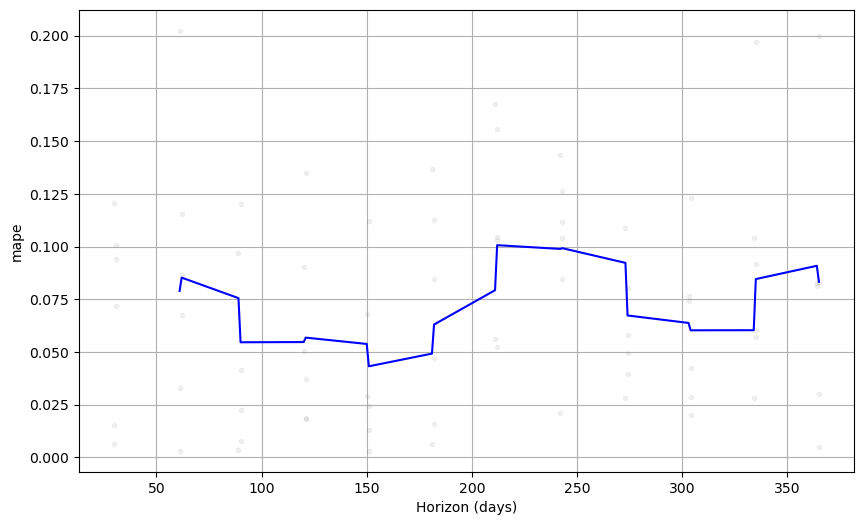

In [16]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

The plot above is the standard output plot of the CV from `prophet`. It is different to what we have looked at before. Each grey point represents a prediction, made on a particular month. Because we made predictions over several horizons each are plotted on the graph. At around horizon 30 for example we see each of the plots over the first month of each of the 6, 12 month validations. The blue line shows a rolling window of the mape scores 'averaged' over the cv predictions. More info [here](https://facebook.github.io/prophet/docs/diagnostics.html).

We are normally interested in the mean and std of the MAPE scores found at each window. This can be calculated from the dataframe returned from the `cross_validation` function above, using the function below. 

In [17]:
def mape_performance_calc(df_cv):
    " function to replace prophet cv 'performance metrics' function"
    df_cv['mape'] = abs(df_cv['y'] - df_cv['yhat']) /df_cv['y'] # make column with individual abs normalised values
    results = df_cv.groupby(['cutoff']).mean() # finish mape calc for each of the folds (distinguised in 'cutoff' column of df_cv)
    results = results.describe() # sumarise folds information
    results = results['mape']# # return only mape column
    return(results)

mape_performance_calc(df_cv)

count    6.000000
mean     0.072113
min      0.052698
25%      0.059342
50%      0.066481
75%      0.077062
max      0.109466
std      0.020539
Name: mape, dtype: float64

We find a MAPE of ~7.2% with std ~2%. This would have estimated the error we saw on the test set to a good degree.

## Hyper-parameters

The model plot we saw earlier did not fit very well to the train data. We can change the model assumptions (like hyper-parameters) to change how well it is fitting the train data.

`Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)`

**TODO**

* Try changing some of these. [This](https://medium.com/data-science/implementing-facebook-prophet-efficiently-c241305405a3) blog is very useful in explaining the parameters and what they do.
* Find at least one change which improves your model cross validation score

10:36:35 - cmdstanpy - INFO - Chain [1] start processing
10:36:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:37 - cmdstanpy - INFO - Chain [1] done processing
10:36:37 - cmdstanpy - INFO - Chain [1] start processing
10:36:37 - cmdstanpy - INFO - Chain [1] done processing
10:36:37 - cmdstanpy - INFO - Chain [1] start processing
10:36:37 - cmdstanpy - INFO - Chain [1] done processing
10:36:37 - cmdstanpy - INFO - Chain [1] start processing
10:36:37 - cmdstanpy - INFO - Chain [1] done processing


count    6.000000
mean     0.057100
min      0.028421
25%      0.036782
50%      0.055517
75%      0.075570
max      0.090350
std      0.025055
Name: mape, dtype: float64

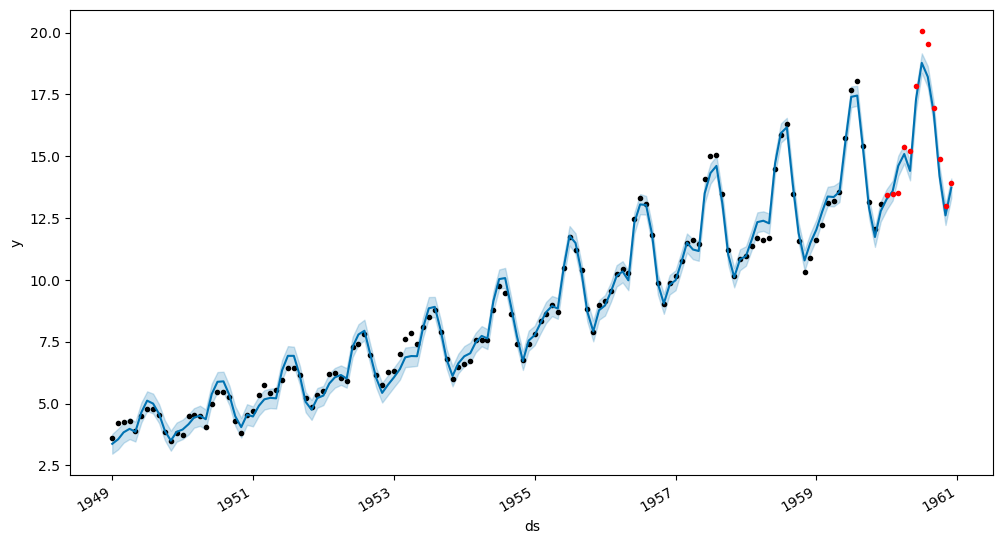

In [18]:
#### your solution here 
prophet = Prophet( growth='linear',
                  changepoints=None,
                  n_changepoints=50,
                  changepoint_range=0.95,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10.0,
                  holidays_prior_scale=10.0,
                  changepoint_prior_scale=0.05,
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=False
)
prophet.fit(train_df)
prophet_future = prophet.make_future_dataframe(periods=12, 
                                                freq='MS', 
                                                include_history=True)
prophet_forecast = prophet.predict(prophet_future)
prophet_y_pred = prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
fig = prophet.plot(prophet_forecast)
test.plot(style='.r')
mape_performance_calc(cross_validation(prophet, 
                                         initial='1461 days', 
                                         period='365 days', 
                                         horizon = '365 days'))


  0%|          | 0/6 [00:00<?, ?it/s]

10:36:37 - cmdstanpy - INFO - Chain [1] start processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processing
10:36:38 - cmdstanpy - INFO - Chain [1] start processing
10:36:38 - cmdstanpy - INFO - Chain [1] done processing
10:36:38 - cmdstanpy - INFO - Chain [1] start processing
10:36:39 - cmdstanpy - INFO - Chain [1] done processing
10:36:39 - cmdstanpy - INFO - Chain [1] start processing
10:36:39 - cmdstanpy - INFO - Chain [1] done processing
10:36:39 - cmdstanpy - INFO - Chain [1] start processing
10:36:39 - cmdstanpy - INFO - Chain [1] done processing
10:36:39 - cmdstanpy - INFO - Chain [1] start processing
10:36:39 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/pytho

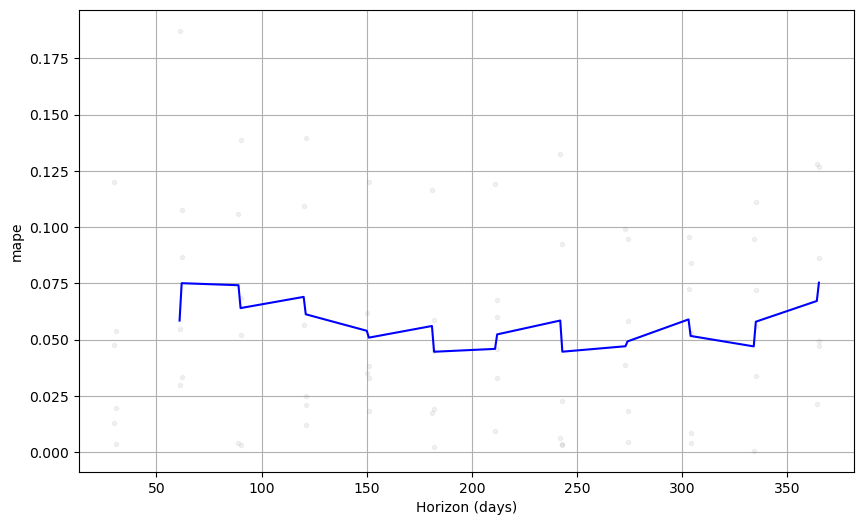

In [19]:
df_cv = cross_validation(prophet, 
                         initial='1461 days', 
                         period='365 days', 
                         horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

In [20]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd

# Ton dataframe Prophet de départ : train_df avec colonnes 'ds' et 'y'

# Choix des paramètres à tester
changepoint_scales = [0.001, 0.01, 0.05, 0.1]
seasonality_scales = [1.0, 5.0, 10.0]
n_changepoints = [10, 20, 30, 50, 70]  # Nombre de points de changement à tester

# Stocker les résultats
results = []

for cps in changepoint_scales:
    for sps in seasonality_scales:
        for n_changepoint in n_changepoints:
            # Crée le modèle avec la combinaison de paramètres
            model = Prophet(
                growth='linear',
                yearly_seasonality='auto',
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps,
                seasonality_mode='multiplicative',  # Utiliser 'multiplicative' par défaut
                n_changepoints=n_changepoint
            )

            try:
                model.fit(train_df)

                # Validation croisée
                df_cv = cross_validation(model, 
                                         initial='1461 days', 
                                         period='365 days', 
                                         horizon='365 days',
                                         parallel="processes")

                df_p = performance_metrics(df_cv)
                mape = df_p['mape'].mean()

                results.append({
                    'changepoint_prior_scale': cps,
                    'seasonality_prior_scale': sps,
                    'seasonality_mode': 'multiplicative',  # Utilisé par défaut
                    'mape': mape,
                    'n_changepoints': n_changepoint
                })

                print(f"Testé: cps={cps}, sps={sps}, mode={'multiplicative'}, nb={n_changepoint} ➤ MAPE={mape:.4f}")

            except Exception as e:
                print(f"Échec pour cps={cps}, sps={sps}, mode={'multiplicative'}, nb={n_changepoint}' ➤ {str(e)}")

# Résultats triés
results_df = pd.DataFrame(results).sort_values(by="mape")
results_df


10:36:40 - cmdstanpy - INFO - Chain [1] start processing
10:36:40 - cmdstanpy - INFO - Chain [1] done processing
10:36:41 - cmdstanpy - INFO - Chain [1] start processing
10:36:41 - cmdstanpy - INFO - Chain [1] start processing
10:36:41 - cmdstanpy - INFO - Chain [1] start processing
10:36:41 - cmdstanpy - INFO - Chain [1] start processing
10:36:41 - cmdstanpy - INFO - Chain [1] done processing
10:36:41 - cmdstanpy - INFO - Chain [1] start processing
10:36:41 - cmdstanpy - INFO - Chain [1] done processing
10:36:41 - cmdstanpy - INFO - Chain [1] start processing
10:36:41 - cmdstanpy - INFO - Chain [1] done processing
10:36:41 - cmdstanpy - INFO - Chain [1] done processing
10:36:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:41 - cmdstanpy - INFO - Chain [1] start processing
10:36:41 - cmdstanpy - INFO - Chain [1] done processing
10:36:41 - cmdstanpy - INFO - Chain [1] done process

Testé: cps=0.001, sps=1.0, mode=multiplicative, nb=10 ➤ MAPE=0.0589


10:36:41 - cmdstanpy - INFO - Chain [1] done processing
10:36:43 - cmdstanpy - INFO - Chain [1] start processing
10:36:43 - cmdstanpy - INFO - Chain [1] start processing
10:36:43 - cmdstanpy - INFO - Chain [1] start processing
10:36:43 - cmdstanpy - INFO - Chain [1] start processing
10:36:43 - cmdstanpy - INFO - Chain [1] start processing
10:36:43 - cmdstanpy - INFO - Chain [1] start processing
10:36:43 - cmdstanpy - INFO - Chain [1] done processing
10:36:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:43 - cmdstanpy - INFO - Chain [1] start processing
10:36:43 - cmdstanpy - INFO - Chain [1] done processing
10:36:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:43 - cmdstanpy - INFO - Chain [1] start processing
10:36:43 - cmdstanpy - INFO - Chain [1] done processing
10:36:43

Testé: cps=0.001, sps=1.0, mode=multiplicative, nb=20 ➤ MAPE=0.0573


10:36:43 - cmdstanpy - INFO - Chain [1] done processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] done processing
10:36:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] done processing
10:36:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] done processing
10:36:44

Testé: cps=0.001, sps=1.0, mode=multiplicative, nb=30 ➤ MAPE=0.0568


10:36:45 - cmdstanpy - INFO - Chain [1] done processing
10:36:46 - cmdstanpy - INFO - Chain [1] start processing
10:36:46 - cmdstanpy - INFO - Chain [1] start processing
10:36:46 - cmdstanpy - INFO - Chain [1] start processing
10:36:46 - cmdstanpy - INFO - Chain [1] start processing
10:36:46 - cmdstanpy - INFO - Chain [1] start processing
10:36:46 - cmdstanpy - INFO - Chain [1] start processing
10:36:46 - cmdstanpy - INFO - Chain [1] done processing
10:36:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:46 - cmdstanpy - INFO - Chain [1] done processing
10:36:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:46 - cmdstanpy - INFO - Chain [1] start processing
10:36:46 - cmdstanpy - INFO - Chain [1] start processing
10:36:46 - cmdstanpy - INFO - Chain [1] done processing
10:36:46

Testé: cps=0.001, sps=1.0, mode=multiplicative, nb=50 ➤ MAPE=0.0560


10:36:48 - cmdstanpy - INFO - Chain [1] done processing
10:36:49 - cmdstanpy - INFO - Chain [1] start processing
10:36:49 - cmdstanpy - INFO - Chain [1] start processing
10:36:49 - cmdstanpy - INFO - Chain [1] start processing
10:36:49 - cmdstanpy - INFO - Chain [1] start processing
10:36:49 - cmdstanpy - INFO - Chain [1] start processing
10:36:49 - cmdstanpy - INFO - Chain [1] start processing
10:36:49 - cmdstanpy - INFO - Chain [1] done processing
10:36:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:49 - cmdstanpy - INFO - Chain [1] done processing
10:36:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:49 - cmdstanpy - INFO - Chain [1] start processing
10:36:49 - cmdstanpy - INFO - Chain [1] start processing
10:36:49 - cmdstanpy - INFO - Chain [1] done processing
10:36:49

Testé: cps=0.001, sps=1.0, mode=multiplicative, nb=70 ➤ MAPE=0.0573


10:36:51 - cmdstanpy - INFO - Chain [1] start processing
10:36:51 - cmdstanpy - INFO - Chain [1] start processing
10:36:51 - cmdstanpy - INFO - Chain [1] done processing
10:36:51 - cmdstanpy - INFO - Chain [1] start processing
10:36:51 - cmdstanpy - INFO - Chain [1] start processing
10:36:51 - cmdstanpy - INFO - Chain [1] start processing
10:36:51 - cmdstanpy - INFO - Chain [1] done processing
10:36:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:51 - cmdstanpy - INFO - Chain [1] start processing
10:36:51 - cmdstanpy - INFO - Chain [1] start processing
10:36:51 - cmdstanpy - INFO - Chain [1] done processing
10:36:51 - cmdstanpy - INFO - Chain [1] done processing
10:36:51 - cmdstanpy - INFO - Chain [1] done processing
10:36:51 - cmdstanpy - INFO - Chain [1] done processing
10:36:51 - cmdstanpy - INFO - Chain [1] done processing
10:36:51 - cmdstanpy - INFO - Chain [1] start process

Testé: cps=0.001, sps=5.0, mode=multiplicative, nb=10 ➤ MAPE=0.0602


10:36:51 - cmdstanpy - INFO - Chain [1] done processing
10:36:53 - cmdstanpy - INFO - Chain [1] start processing
10:36:53 - cmdstanpy - INFO - Chain [1] start processing
10:36:53 - cmdstanpy - INFO - Chain [1] start processing
10:36:53 - cmdstanpy - INFO - Chain [1] start processing
10:36:53 - cmdstanpy - INFO - Chain [1] done processing
10:36:53 - cmdstanpy - INFO - Chain [1] start processing
10:36:53 - cmdstanpy - INFO - Chain [1] start processing
10:36:53 - cmdstanpy - INFO - Chain [1] done processing
10:36:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:53 - cmdstanpy - INFO - Chain [1] done processing
10:36:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:53 - cmdstanpy - INFO - Chain [1] start processing
10:36:53 - cmdstanpy - INFO - Chain [1] start processing
10:36:53

Testé: cps=0.001, sps=5.0, mode=multiplicative, nb=20 ➤ MAPE=0.0564


10:36:53 - cmdstanpy - INFO - Chain [1] done processing
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] done processing
10:36:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] done processing
10:36:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:54 - cmdstanpy - INFO - Chain [1] done processing
10:36:55

Testé: cps=0.001, sps=5.0, mode=multiplicative, nb=30 ➤ MAPE=0.0573


10:36:55 - cmdstanpy - INFO - Chain [1] done processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] done processing
10:36:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] done processing
10:36:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:57 - cmdstanpy - INFO - Chain [1] done processing
10:36:57

Testé: cps=0.001, sps=5.0, mode=multiplicative, nb=50 ➤ MAPE=0.0561


10:36:58 - cmdstanpy - INFO - Chain [1] done processing
10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:36:59 - cmdstanpy - INFO - Chain [1] done processing
10:36:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:36:59 - cmdstanpy - INFO - Chain [1] done processing
10:36:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:36:59 - cmdstanpy - INFO - Chain [1] done processing
10:36:59

Testé: cps=0.001, sps=5.0, mode=multiplicative, nb=70 ➤ MAPE=0.0561


10:37:01 - cmdstanpy - INFO - Chain [1] start processing
10:37:01 - cmdstanpy - INFO - Chain [1] done processing
10:37:01 - cmdstanpy - INFO - Chain [1] start processing
10:37:01 - cmdstanpy - INFO - Chain [1] start processing
10:37:01 - cmdstanpy - INFO - Chain [1] start processing
10:37:01 - cmdstanpy - INFO - Chain [1] start processing
10:37:01 - cmdstanpy - INFO - Chain [1] done processing
10:37:01 - cmdstanpy - INFO - Chain [1] start processing
10:37:01 - cmdstanpy - INFO - Chain [1] done processing
10:37:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:01 - cmdstanpy - INFO - Chain [1] start processing
10:37:01 - cmdstanpy - INFO - Chain [1] done processing
10:37:01 - cmdstanpy - INFO - Chain [1] done processing
10:37:01 - cmdstanpy - INFO - Chain [1] done processing
10:37:01 - cmdstanpy - INFO - Chain [1] done processing
10:37:01 - cmdstanpy - INFO - Chain [1] start process

Testé: cps=0.001, sps=10.0, mode=multiplicative, nb=10 ➤ MAPE=0.0599


10:37:02 - cmdstanpy - INFO - Chain [1] done processing
10:37:03 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] done processing
10:37:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:03 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] done processing
10:37:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:03 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] done processing
10:37:03

Testé: cps=0.001, sps=10.0, mode=multiplicative, nb=20 ➤ MAPE=0.0555


10:37:03 - cmdstanpy - INFO - Chain [1] done processing
10:37:05 - cmdstanpy - INFO - Chain [1] start processing
10:37:05 - cmdstanpy - INFO - Chain [1] start processing
10:37:05 - cmdstanpy - INFO - Chain [1] start processing
10:37:05 - cmdstanpy - INFO - Chain [1] start processing
10:37:05 - cmdstanpy - INFO - Chain [1] start processing
10:37:05 - cmdstanpy - INFO - Chain [1] start processing
10:37:05 - cmdstanpy - INFO - Chain [1] done processing
10:37:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:05 - cmdstanpy - INFO - Chain [1] start processing
10:37:05 - cmdstanpy - INFO - Chain [1] done processing
10:37:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:05 - cmdstanpy - INFO - Chain [1] start processing
10:37:05 - cmdstanpy - INFO - Chain [1] done processing
10:37:05

Testé: cps=0.001, sps=10.0, mode=multiplicative, nb=30 ➤ MAPE=0.0560


10:37:05 - cmdstanpy - INFO - Chain [1] done processing
10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:06 - cmdstanpy - INFO - Chain [1] done processing
10:37:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:06 - cmdstanpy - INFO - Chain [1] done processing
10:37:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:07 - cmdstanpy - INFO - Chain [1] done processing
10:37:07

Testé: cps=0.001, sps=10.0, mode=multiplicative, nb=50 ➤ MAPE=0.0560


10:37:07 - cmdstanpy - INFO - Chain [1] done processing
10:37:08 - cmdstanpy - INFO - Chain [1] start processing
10:37:08 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] done processing
10:37:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:09 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] done processing
10:37:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:09 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] done processing
10:37:09

Testé: cps=0.001, sps=10.0, mode=multiplicative, nb=70 ➤ MAPE=0.0563


10:37:11 - cmdstanpy - INFO - Chain [1] start processing
10:37:11 - cmdstanpy - INFO - Chain [1] start processing
10:37:11 - cmdstanpy - INFO - Chain [1] start processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing
10:37:11 - cmdstanpy - INFO - Chain [1] start processing
10:37:11 - cmdstanpy - INFO - Chain [1] start processing
10:37:11 - cmdstanpy - INFO - Chain [1] start processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing
10:37:11 - cmdstanpy - INFO - Chain [1] start processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=1.0, mode=multiplicative, nb=10 ➤ MAPE=0.0530


10:37:12 - cmdstanpy - INFO - Chain [1] start processing
10:37:12 - cmdstanpy - INFO - Chain [1] start processing
10:37:12 - cmdstanpy - INFO - Chain [1] start processing
10:37:12 - cmdstanpy - INFO - Chain [1] start processing
10:37:12 - cmdstanpy - INFO - Chain [1] start processing
10:37:12 - cmdstanpy - INFO - Chain [1] done processing
10:37:12 - cmdstanpy - INFO - Chain [1] start processing
10:37:13 - cmdstanpy - INFO - Chain [1] done processing
10:37:13 - cmdstanpy - INFO - Chain [1] done processing
10:37:13 - cmdstanpy - INFO - Chain [1] done processing
10:37:13 - cmdstanpy - INFO - Chain [1] done processing
10:37:13 - cmdstanpy - INFO - Chain [1] done processing
10:37:13 - cmdstanpy - INFO - Chain [1] start processing
10:37:13 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=1.0, mode=multiplicative, nb=20 ➤ MAPE=0.0527


10:37:14 - cmdstanpy - INFO - Chain [1] start processing
10:37:14 - cmdstanpy - INFO - Chain [1] start processing
10:37:14 - cmdstanpy - INFO - Chain [1] start processing
10:37:14 - cmdstanpy - INFO - Chain [1] start processing
10:37:14 - cmdstanpy - INFO - Chain [1] start processing
10:37:14 - cmdstanpy - INFO - Chain [1] start processing
10:37:14 - cmdstanpy - INFO - Chain [1] done processing
10:37:14 - cmdstanpy - INFO - Chain [1] done processing
10:37:15 - cmdstanpy - INFO - Chain [1] done processing
10:37:15 - cmdstanpy - INFO - Chain [1] done processing
10:37:15 - cmdstanpy - INFO - Chain [1] done processing
10:37:15 - cmdstanpy - INFO - Chain [1] done processing
10:37:15 - cmdstanpy - INFO - Chain [1] start processing
10:37:15 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=1.0, mode=multiplicative, nb=30 ➤ MAPE=0.0531


10:37:16 - cmdstanpy - INFO - Chain [1] start processing
10:37:16 - cmdstanpy - INFO - Chain [1] start processing
10:37:16 - cmdstanpy - INFO - Chain [1] start processing
10:37:16 - cmdstanpy - INFO - Chain [1] start processing
10:37:16 - cmdstanpy - INFO - Chain [1] start processing
10:37:16 - cmdstanpy - INFO - Chain [1] done processing
10:37:16 - cmdstanpy - INFO - Chain [1] start processing
10:37:16 - cmdstanpy - INFO - Chain [1] done processing
10:37:16 - cmdstanpy - INFO - Chain [1] done processing
10:37:17 - cmdstanpy - INFO - Chain [1] done processing
10:37:17 - cmdstanpy - INFO - Chain [1] done processing
10:37:17 - cmdstanpy - INFO - Chain [1] done processing
10:37:17 - cmdstanpy - INFO - Chain [1] start processing
10:37:17 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=1.0, mode=multiplicative, nb=50 ➤ MAPE=0.0525


10:37:18 - cmdstanpy - INFO - Chain [1] start processing
10:37:18 - cmdstanpy - INFO - Chain [1] start processing
10:37:18 - cmdstanpy - INFO - Chain [1] start processing
10:37:18 - cmdstanpy - INFO - Chain [1] start processing
10:37:18 - cmdstanpy - INFO - Chain [1] start processing
10:37:18 - cmdstanpy - INFO - Chain [1] done processing
10:37:18 - cmdstanpy - INFO - Chain [1] start processing
10:37:18 - cmdstanpy - INFO - Chain [1] done processing
10:37:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:18 - cmdstanpy - INFO - Chain [1] start processing
10:37:19 - cmdstanpy - INFO - Chain [1] done processing
10:37:19 - cmdstanpy - INFO - Chain [1] done processing
10:37:19 - cmdstanpy - INFO - Chain [1] done processing
10:37:19 - cmdstanpy - INFO - Chain [1] done processing
10:37:19 - cmdstanpy - INFO - Chain [1] done processing
10:37:19 - cmdstanpy - INFO - Chain [1] start process

Testé: cps=0.01, sps=1.0, mode=multiplicative, nb=70 ➤ MAPE=0.0520


10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=5.0, mode=multiplicative, nb=10 ➤ MAPE=0.0538


10:37:23 - cmdstanpy - INFO - Chain [1] start processing
10:37:23 - cmdstanpy - INFO - Chain [1] start processing
10:37:23 - cmdstanpy - INFO - Chain [1] start processing
10:37:23 - cmdstanpy - INFO - Chain [1] start processing
10:37:23 - cmdstanpy - INFO - Chain [1] start processing
10:37:23 - cmdstanpy - INFO - Chain [1] start processing
10:37:23 - cmdstanpy - INFO - Chain [1] done processing
10:37:23 - cmdstanpy - INFO - Chain [1] done processing
10:37:23 - cmdstanpy - INFO - Chain [1] done processing
10:37:23 - cmdstanpy - INFO - Chain [1] done processing
10:37:23 - cmdstanpy - INFO - Chain [1] done processing
10:37:23 - cmdstanpy - INFO - Chain [1] done processing
10:37:23 - cmdstanpy - INFO - Chain [1] start processing
10:37:23 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=5.0, mode=multiplicative, nb=20 ➤ MAPE=0.0528


10:37:25 - cmdstanpy - INFO - Chain [1] start processing
10:37:25 - cmdstanpy - INFO - Chain [1] start processing
10:37:25 - cmdstanpy - INFO - Chain [1] start processing
10:37:25 - cmdstanpy - INFO - Chain [1] start processing
10:37:25 - cmdstanpy - INFO - Chain [1] start processing
10:37:25 - cmdstanpy - INFO - Chain [1] done processing
10:37:25 - cmdstanpy - INFO - Chain [1] start processing
10:37:25 - cmdstanpy - INFO - Chain [1] done processing
10:37:25 - cmdstanpy - INFO - Chain [1] done processing
10:37:25 - cmdstanpy - INFO - Chain [1] done processing
10:37:25 - cmdstanpy - INFO - Chain [1] done processing
10:37:25 - cmdstanpy - INFO - Chain [1] done processing
10:37:25 - cmdstanpy - INFO - Chain [1] start processing
10:37:25 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=5.0, mode=multiplicative, nb=30 ➤ MAPE=0.0534


10:37:27 - cmdstanpy - INFO - Chain [1] start processing
10:37:27 - cmdstanpy - INFO - Chain [1] start processing
10:37:27 - cmdstanpy - INFO - Chain [1] start processing
10:37:27 - cmdstanpy - INFO - Chain [1] start processing
10:37:27 - cmdstanpy - INFO - Chain [1] start processing
10:37:27 - cmdstanpy - INFO - Chain [1] start processing
10:37:27 - cmdstanpy - INFO - Chain [1] done processing
10:37:27 - cmdstanpy - INFO - Chain [1] done processing
10:37:27 - cmdstanpy - INFO - Chain [1] done processing
10:37:27 - cmdstanpy - INFO - Chain [1] done processing
10:37:27 - cmdstanpy - INFO - Chain [1] done processing
10:37:28 - cmdstanpy - INFO - Chain [1] done processing
10:37:28 - cmdstanpy - INFO - Chain [1] start processing
10:37:28 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=5.0, mode=multiplicative, nb=50 ➤ MAPE=0.0535


10:37:29 - cmdstanpy - INFO - Chain [1] start processing
10:37:29 - cmdstanpy - INFO - Chain [1] start processing
10:37:29 - cmdstanpy - INFO - Chain [1] start processing
10:37:30 - cmdstanpy - INFO - Chain [1] start processing
10:37:30 - cmdstanpy - INFO - Chain [1] start processing
10:37:30 - cmdstanpy - INFO - Chain [1] start processing
10:37:30 - cmdstanpy - INFO - Chain [1] done processing
10:37:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:30 - cmdstanpy - INFO - Chain [1] start processing
10:37:30 - cmdstanpy - INFO - Chain [1] done processing
10:37:30 - cmdstanpy - INFO - Chain [1] done processing
10:37:30 - cmdstanpy - INFO - Chain [1] done processing
10:37:30 - cmdstanpy - INFO - Chain [1] done processing
10:37:31 - cmdstanpy - INFO - Chain [1] done processing
10:37:31 - cmdstanpy - INFO - Chain [1] done processing
10:37:31 - cmdstanpy - INFO - Chain [1] start process

Testé: cps=0.01, sps=5.0, mode=multiplicative, nb=70 ➤ MAPE=0.0525


10:37:32 - cmdstanpy - INFO - Chain [1] start processing
10:37:32 - cmdstanpy - INFO - Chain [1] start processing
10:37:32 - cmdstanpy - INFO - Chain [1] start processing
10:37:32 - cmdstanpy - INFO - Chain [1] done processing
10:37:32 - cmdstanpy - INFO - Chain [1] start processing
10:37:32 - cmdstanpy - INFO - Chain [1] start processing
10:37:32 - cmdstanpy - INFO - Chain [1] start processing
10:37:32 - cmdstanpy - INFO - Chain [1] done processing
10:37:33 - cmdstanpy - INFO - Chain [1] done processing
10:37:33 - cmdstanpy - INFO - Chain [1] done processing
10:37:33 - cmdstanpy - INFO - Chain [1] done processing
10:37:33 - cmdstanpy - INFO - Chain [1] done processing
10:37:33 - cmdstanpy - INFO - Chain [1] start processing
10:37:33 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=10.0, mode=multiplicative, nb=10 ➤ MAPE=0.0538


10:37:35 - cmdstanpy - INFO - Chain [1] start processing
10:37:35 - cmdstanpy - INFO - Chain [1] start processing
10:37:35 - cmdstanpy - INFO - Chain [1] start processing
10:37:35 - cmdstanpy - INFO - Chain [1] start processing
10:37:35 - cmdstanpy - INFO - Chain [1] done processing
10:37:35 - cmdstanpy - INFO - Chain [1] start processing
10:37:35 - cmdstanpy - INFO - Chain [1] start processing
10:37:35 - cmdstanpy - INFO - Chain [1] done processing
10:37:35 - cmdstanpy - INFO - Chain [1] done processing
10:37:35 - cmdstanpy - INFO - Chain [1] done processing
10:37:35 - cmdstanpy - INFO - Chain [1] done processing
10:37:35 - cmdstanpy - INFO - Chain [1] done processing
10:37:35 - cmdstanpy - INFO - Chain [1] start processing
10:37:35 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=10.0, mode=multiplicative, nb=20 ➤ MAPE=0.0526


10:37:38 - cmdstanpy - INFO - Chain [1] start processing
10:37:38 - cmdstanpy - INFO - Chain [1] start processing
10:37:38 - cmdstanpy - INFO - Chain [1] start processing
10:37:38 - cmdstanpy - INFO - Chain [1] start processing
10:37:38 - cmdstanpy - INFO - Chain [1] start processing
10:37:38 - cmdstanpy - INFO - Chain [1] start processing
10:37:38 - cmdstanpy - INFO - Chain [1] done processing
10:37:38 - cmdstanpy - INFO - Chain [1] done processing
10:37:38 - cmdstanpy - INFO - Chain [1] done processing
10:37:38 - cmdstanpy - INFO - Chain [1] done processing
10:37:38 - cmdstanpy - INFO - Chain [1] done processing
10:37:38 - cmdstanpy - INFO - Chain [1] done processing
10:37:38 - cmdstanpy - INFO - Chain [1] start processing
10:37:38 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=10.0, mode=multiplicative, nb=30 ➤ MAPE=0.0528


10:37:40 - cmdstanpy - INFO - Chain [1] start processing
10:37:41 - cmdstanpy - INFO - Chain [1] start processing
10:37:41 - cmdstanpy - INFO - Chain [1] start processing
10:37:41 - cmdstanpy - INFO - Chain [1] start processing
10:37:41 - cmdstanpy - INFO - Chain [1] start processing
10:37:41 - cmdstanpy - INFO - Chain [1] start processing
10:37:41 - cmdstanpy - INFO - Chain [1] done processing
10:37:41 - cmdstanpy - INFO - Chain [1] done processing
10:37:41 - cmdstanpy - INFO - Chain [1] done processing
10:37:41 - cmdstanpy - INFO - Chain [1] done processing
10:37:41 - cmdstanpy - INFO - Chain [1] done processing
10:37:41 - cmdstanpy - INFO - Chain [1] done processing
10:37:41 - cmdstanpy - INFO - Chain [1] start processing
10:37:42 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.01, sps=10.0, mode=multiplicative, nb=50 ➤ MAPE=0.0540


10:37:43 - cmdstanpy - INFO - Chain [1] start processing
10:37:43 - cmdstanpy - INFO - Chain [1] done processing
10:37:43 - cmdstanpy - INFO - Chain [1] start processing
10:37:43 - cmdstanpy - INFO - Chain [1] start processing
10:37:43 - cmdstanpy - INFO - Chain [1] start processing
10:37:43 - cmdstanpy - INFO - Chain [1] start processing
10:37:43 - cmdstanpy - INFO - Chain [1] start processing
10:37:43 - cmdstanpy - INFO - Chain [1] done processing
10:37:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:37:43 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] done processing
10:37:45 - cmdstanpy - INFO - Chain [1] done processing
10:37:45 - cmdstanpy - INFO - Chain [1] done processing
10:37:45 - cmdstanpy - INFO - Chain [1] start process

Testé: cps=0.01, sps=10.0, mode=multiplicative, nb=70 ➤ MAPE=0.0519


10:37:47 - cmdstanpy - INFO - Chain [1] start processing
10:37:47 - cmdstanpy - INFO - Chain [1] start processing
10:37:47 - cmdstanpy - INFO - Chain [1] start processing
10:37:47 - cmdstanpy - INFO - Chain [1] start processing
10:37:47 - cmdstanpy - INFO - Chain [1] start processing
10:37:47 - cmdstanpy - INFO - Chain [1] start processing
10:37:47 - cmdstanpy - INFO - Chain [1] done processing
10:37:47 - cmdstanpy - INFO - Chain [1] done processing
10:37:47 - cmdstanpy - INFO - Chain [1] done processing
10:37:48 - cmdstanpy - INFO - Chain [1] done processing
10:37:48 - cmdstanpy - INFO - Chain [1] done processing
10:37:48 - cmdstanpy - INFO - Chain [1] done processing
10:37:48 - cmdstanpy - INFO - Chain [1] start processing
10:37:48 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=1.0, mode=multiplicative, nb=10 ➤ MAPE=0.0549


10:37:50 - cmdstanpy - INFO - Chain [1] start processing
10:37:50 - cmdstanpy - INFO - Chain [1] start processing
10:37:50 - cmdstanpy - INFO - Chain [1] start processing
10:37:50 - cmdstanpy - INFO - Chain [1] start processing
10:37:50 - cmdstanpy - INFO - Chain [1] start processing
10:37:50 - cmdstanpy - INFO - Chain [1] start processing
10:37:50 - cmdstanpy - INFO - Chain [1] done processing
10:37:50 - cmdstanpy - INFO - Chain [1] done processing
10:37:50 - cmdstanpy - INFO - Chain [1] done processing
10:37:50 - cmdstanpy - INFO - Chain [1] done processing
10:37:50 - cmdstanpy - INFO - Chain [1] done processing
10:37:50 - cmdstanpy - INFO - Chain [1] done processing
10:37:50 - cmdstanpy - INFO - Chain [1] start processing
10:37:50 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=1.0, mode=multiplicative, nb=20 ➤ MAPE=0.0543


10:37:52 - cmdstanpy - INFO - Chain [1] start processing
10:37:52 - cmdstanpy - INFO - Chain [1] start processing
10:37:53 - cmdstanpy - INFO - Chain [1] start processing
10:37:53 - cmdstanpy - INFO - Chain [1] start processing
10:37:53 - cmdstanpy - INFO - Chain [1] done processing
10:37:53 - cmdstanpy - INFO - Chain [1] start processing
10:37:53 - cmdstanpy - INFO - Chain [1] start processing
10:37:53 - cmdstanpy - INFO - Chain [1] done processing
10:37:53 - cmdstanpy - INFO - Chain [1] done processing
10:37:53 - cmdstanpy - INFO - Chain [1] done processing
10:37:53 - cmdstanpy - INFO - Chain [1] done processing
10:37:53 - cmdstanpy - INFO - Chain [1] done processing
10:37:53 - cmdstanpy - INFO - Chain [1] start processing
10:37:53 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=1.0, mode=multiplicative, nb=30 ➤ MAPE=0.0538


10:37:56 - cmdstanpy - INFO - Chain [1] start processing
10:37:56 - cmdstanpy - INFO - Chain [1] start processing
10:37:56 - cmdstanpy - INFO - Chain [1] start processing
10:37:56 - cmdstanpy - INFO - Chain [1] start processing
10:37:56 - cmdstanpy - INFO - Chain [1] start processing
10:37:56 - cmdstanpy - INFO - Chain [1] done processing
10:37:56 - cmdstanpy - INFO - Chain [1] start processing
10:37:56 - cmdstanpy - INFO - Chain [1] done processing
10:37:56 - cmdstanpy - INFO - Chain [1] done processing
10:37:56 - cmdstanpy - INFO - Chain [1] done processing
10:37:57 - cmdstanpy - INFO - Chain [1] done processing
10:37:57 - cmdstanpy - INFO - Chain [1] done processing
10:37:57 - cmdstanpy - INFO - Chain [1] start processing
10:37:57 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=1.0, mode=multiplicative, nb=50 ➤ MAPE=0.0529


10:37:59 - cmdstanpy - INFO - Chain [1] start processing
10:37:59 - cmdstanpy - INFO - Chain [1] start processing
10:37:59 - cmdstanpy - INFO - Chain [1] start processing
10:37:59 - cmdstanpy - INFO - Chain [1] start processing
10:37:59 - cmdstanpy - INFO - Chain [1] start processing
10:37:59 - cmdstanpy - INFO - Chain [1] start processing
10:37:59 - cmdstanpy - INFO - Chain [1] done processing
10:37:59 - cmdstanpy - INFO - Chain [1] done processing
10:38:00 - cmdstanpy - INFO - Chain [1] done processing
10:38:00 - cmdstanpy - INFO - Chain [1] done processing
10:38:01 - cmdstanpy - INFO - Chain [1] done processing
10:38:01 - cmdstanpy - INFO - Chain [1] done processing
10:38:01 - cmdstanpy - INFO - Chain [1] start processing
10:38:01 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=1.0, mode=multiplicative, nb=70 ➤ MAPE=0.0528


10:38:04 - cmdstanpy - INFO - Chain [1] start processing
10:38:04 - cmdstanpy - INFO - Chain [1] start processing
10:38:04 - cmdstanpy - INFO - Chain [1] start processing
10:38:04 - cmdstanpy - INFO - Chain [1] start processing
10:38:04 - cmdstanpy - INFO - Chain [1] start processing
10:38:04 - cmdstanpy - INFO - Chain [1] start processing
10:38:04 - cmdstanpy - INFO - Chain [1] done processing
10:38:04 - cmdstanpy - INFO - Chain [1] done processing
10:38:04 - cmdstanpy - INFO - Chain [1] done processing
10:38:04 - cmdstanpy - INFO - Chain [1] done processing
10:38:04 - cmdstanpy - INFO - Chain [1] done processing
10:38:04 - cmdstanpy - INFO - Chain [1] done processing
10:38:04 - cmdstanpy - INFO - Chain [1] start processing
10:38:04 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=5.0, mode=multiplicative, nb=10 ➤ MAPE=0.0550


10:38:07 - cmdstanpy - INFO - Chain [1] start processing
10:38:07 - cmdstanpy - INFO - Chain [1] start processing
10:38:07 - cmdstanpy - INFO - Chain [1] start processing
10:38:07 - cmdstanpy - INFO - Chain [1] start processing
10:38:07 - cmdstanpy - INFO - Chain [1] done processing
10:38:07 - cmdstanpy - INFO - Chain [1] start processing
10:38:07 - cmdstanpy - INFO - Chain [1] start processing
10:38:07 - cmdstanpy - INFO - Chain [1] done processing
10:38:07 - cmdstanpy - INFO - Chain [1] done processing
10:38:07 - cmdstanpy - INFO - Chain [1] done processing
10:38:07 - cmdstanpy - INFO - Chain [1] done processing
10:38:07 - cmdstanpy - INFO - Chain [1] done processing
10:38:07 - cmdstanpy - INFO - Chain [1] start processing
10:38:07 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=5.0, mode=multiplicative, nb=20 ➤ MAPE=0.0546


10:38:10 - cmdstanpy - INFO - Chain [1] start processing
10:38:10 - cmdstanpy - INFO - Chain [1] start processing
10:38:10 - cmdstanpy - INFO - Chain [1] start processing
10:38:10 - cmdstanpy - INFO - Chain [1] start processing
10:38:10 - cmdstanpy - INFO - Chain [1] start processing
10:38:10 - cmdstanpy - INFO - Chain [1] start processing
10:38:10 - cmdstanpy - INFO - Chain [1] done processing
10:38:10 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=5.0, mode=multiplicative, nb=30 ➤ MAPE=0.0538


10:38:14 - cmdstanpy - INFO - Chain [1] start processing
10:38:14 - cmdstanpy - INFO - Chain [1] start processing
10:38:14 - cmdstanpy - INFO - Chain [1] start processing
10:38:14 - cmdstanpy - INFO - Chain [1] start processing
10:38:14 - cmdstanpy - INFO - Chain [1] start processing
10:38:14 - cmdstanpy - INFO - Chain [1] done processing
10:38:14 - cmdstanpy - INFO - Chain [1] start processing
10:38:14 - cmdstanpy - INFO - Chain [1] done processing
10:38:15 - cmdstanpy - INFO - Chain [1] done processing
10:38:15 - cmdstanpy - INFO - Chain [1] done processing
10:38:15 - cmdstanpy - INFO - Chain [1] done processing
10:38:16 - cmdstanpy - INFO - Chain [1] done processing
10:38:16 - cmdstanpy - INFO - Chain [1] start processing
10:38:16 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=5.0, mode=multiplicative, nb=50 ➤ MAPE=0.0538


10:38:18 - cmdstanpy - INFO - Chain [1] start processing
10:38:18 - cmdstanpy - INFO - Chain [1] start processing
10:38:18 - cmdstanpy - INFO - Chain [1] start processing
10:38:18 - cmdstanpy - INFO - Chain [1] start processing
10:38:18 - cmdstanpy - INFO - Chain [1] start processing
10:38:18 - cmdstanpy - INFO - Chain [1] start processing
10:38:18 - cmdstanpy - INFO - Chain [1] done processing
10:38:18 - cmdstanpy - INFO - Chain [1] done processing
10:38:19 - cmdstanpy - INFO - Chain [1] done processing
10:38:19 - cmdstanpy - INFO - Chain [1] done processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
10:38:21 - cmdstanpy - INFO - Chain [1] done processing
10:38:21 - cmdstanpy - INFO - Chain [1] start processing
10:38:21 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=5.0, mode=multiplicative, nb=70 ➤ MAPE=0.0540


10:38:23 - cmdstanpy - INFO - Chain [1] start processing
10:38:23 - cmdstanpy - INFO - Chain [1] start processing
10:38:23 - cmdstanpy - INFO - Chain [1] start processing
10:38:23 - cmdstanpy - INFO - Chain [1] start processing
10:38:23 - cmdstanpy - INFO - Chain [1] start processing
10:38:23 - cmdstanpy - INFO - Chain [1] done processing
10:38:23 - cmdstanpy - INFO - Chain [1] start processing
10:38:23 - cmdstanpy - INFO - Chain [1] done processing
10:38:23 - cmdstanpy - INFO - Chain [1] done processing
10:38:23 - cmdstanpy - INFO - Chain [1] done processing
10:38:23 - cmdstanpy - INFO - Chain [1] done processing
10:38:24 - cmdstanpy - INFO - Chain [1] done processing
10:38:24 - cmdstanpy - INFO - Chain [1] start processing
10:38:24 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=10.0, mode=multiplicative, nb=10 ➤ MAPE=0.0549


10:38:26 - cmdstanpy - INFO - Chain [1] start processing
10:38:26 - cmdstanpy - INFO - Chain [1] start processing
10:38:26 - cmdstanpy - INFO - Chain [1] start processing
10:38:26 - cmdstanpy - INFO - Chain [1] start processing
10:38:26 - cmdstanpy - INFO - Chain [1] start processing
10:38:26 - cmdstanpy - INFO - Chain [1] start processing
10:38:26 - cmdstanpy - INFO - Chain [1] done processing
10:38:26 - cmdstanpy - INFO - Chain [1] done processing
10:38:27 - cmdstanpy - INFO - Chain [1] done processing
10:38:27 - cmdstanpy - INFO - Chain [1] done processing
10:38:27 - cmdstanpy - INFO - Chain [1] done processing
10:38:27 - cmdstanpy - INFO - Chain [1] done processing
10:38:27 - cmdstanpy - INFO - Chain [1] start processing
10:38:27 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=10.0, mode=multiplicative, nb=20 ➤ MAPE=0.0540


10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:31 - cmdstanpy - INFO - Chain [1] done processing
10:38:31 - cmdstanpy - INFO - Chain [1] start processing
10:38:31 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=10.0, mode=multiplicative, nb=30 ➤ MAPE=0.0548


10:38:33 - cmdstanpy - INFO - Chain [1] start processing
10:38:33 - cmdstanpy - INFO - Chain [1] start processing
10:38:33 - cmdstanpy - INFO - Chain [1] start processing
10:38:33 - cmdstanpy - INFO - Chain [1] start processing
10:38:33 - cmdstanpy - INFO - Chain [1] start processing
10:38:33 - cmdstanpy - INFO - Chain [1] done processing
10:38:34 - cmdstanpy - INFO - Chain [1] start processing
10:38:34 - cmdstanpy - INFO - Chain [1] done processing
10:38:34 - cmdstanpy - INFO - Chain [1] done processing
10:38:34 - cmdstanpy - INFO - Chain [1] done processing
10:38:34 - cmdstanpy - INFO - Chain [1] done processing
10:38:35 - cmdstanpy - INFO - Chain [1] done processing
10:38:35 - cmdstanpy - INFO - Chain [1] start processing
10:38:35 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=10.0, mode=multiplicative, nb=50 ➤ MAPE=0.0539


10:38:37 - cmdstanpy - INFO - Chain [1] start processing
10:38:37 - cmdstanpy - INFO - Chain [1] start processing
10:38:37 - cmdstanpy - INFO - Chain [1] start processing
10:38:37 - cmdstanpy - INFO - Chain [1] start processing
10:38:37 - cmdstanpy - INFO - Chain [1] start processing
10:38:37 - cmdstanpy - INFO - Chain [1] done processing
10:38:37 - cmdstanpy - INFO - Chain [1] start processing
10:38:37 - cmdstanpy - INFO - Chain [1] done processing
10:38:38 - cmdstanpy - INFO - Chain [1] done processing
10:38:39 - cmdstanpy - INFO - Chain [1] done processing
10:38:39 - cmdstanpy - INFO - Chain [1] done processing
10:38:40 - cmdstanpy - INFO - Chain [1] done processing
10:38:40 - cmdstanpy - INFO - Chain [1] start processing
10:38:40 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.05, sps=10.0, mode=multiplicative, nb=70 ➤ MAPE=0.0535


10:38:43 - cmdstanpy - INFO - Chain [1] start processing
10:38:43 - cmdstanpy - INFO - Chain [1] start processing
10:38:43 - cmdstanpy - INFO - Chain [1] done processing
10:38:43 - cmdstanpy - INFO - Chain [1] start processing
10:38:43 - cmdstanpy - INFO - Chain [1] start processing
10:38:43 - cmdstanpy - INFO - Chain [1] start processing
10:38:43 - cmdstanpy - INFO - Chain [1] start processing
10:38:43 - cmdstanpy - INFO - Chain [1] done processing
10:38:43 - cmdstanpy - INFO - Chain [1] done processing
10:38:43 - cmdstanpy - INFO - Chain [1] done processing
10:38:43 - cmdstanpy - INFO - Chain [1] done processing
10:38:43 - cmdstanpy - INFO - Chain [1] done processing
10:38:43 - cmdstanpy - INFO - Chain [1] start processing
10:38:43 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=1.0, mode=multiplicative, nb=10 ➤ MAPE=0.0550


10:38:46 - cmdstanpy - INFO - Chain [1] start processing
10:38:46 - cmdstanpy - INFO - Chain [1] start processing
10:38:46 - cmdstanpy - INFO - Chain [1] start processing
10:38:46 - cmdstanpy - INFO - Chain [1] start processing
10:38:46 - cmdstanpy - INFO - Chain [1] start processing
10:38:46 - cmdstanpy - INFO - Chain [1] start processing
10:38:46 - cmdstanpy - INFO - Chain [1] done processing
10:38:46 - cmdstanpy - INFO - Chain [1] done processing
10:38:47 - cmdstanpy - INFO - Chain [1] done processing
10:38:47 - cmdstanpy - INFO - Chain [1] done processing
10:38:47 - cmdstanpy - INFO - Chain [1] done processing
10:38:47 - cmdstanpy - INFO - Chain [1] done processing
10:38:47 - cmdstanpy - INFO - Chain [1] start processing
10:38:47 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=1.0, mode=multiplicative, nb=20 ➤ MAPE=0.0550


10:38:49 - cmdstanpy - INFO - Chain [1] start processing
10:38:49 - cmdstanpy - INFO - Chain [1] start processing
10:38:49 - cmdstanpy - INFO - Chain [1] start processing
10:38:49 - cmdstanpy - INFO - Chain [1] start processing
10:38:49 - cmdstanpy - INFO - Chain [1] done processing
10:38:49 - cmdstanpy - INFO - Chain [1] start processing
10:38:49 - cmdstanpy - INFO - Chain [1] start processing
10:38:49 - cmdstanpy - INFO - Chain [1] done processing
10:38:50 - cmdstanpy - INFO - Chain [1] done processing
10:38:50 - cmdstanpy - INFO - Chain [1] done processing
10:38:50 - cmdstanpy - INFO - Chain [1] done processing
10:38:50 - cmdstanpy - INFO - Chain [1] done processing
10:38:50 - cmdstanpy - INFO - Chain [1] start processing
10:38:50 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=1.0, mode=multiplicative, nb=30 ➤ MAPE=0.0545


10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] done processing
10:38:53 - cmdstanpy - INFO - Chain [1] start processing
10:38:53 - cmdstanpy - INFO - Chain [1] start processing
10:38:53 - cmdstanpy - INFO - Chain [1] done processing
10:38:53 - cmdstanpy - INFO - Chain [1] done processing
10:38:53 - cmdstanpy - INFO - Chain [1] done processing
10:38:54 - cmdstanpy - INFO - Chain [1] done processing
10:38:54 - cmdstanpy - INFO - Chain [1] done processing
10:38:54 - cmdstanpy - INFO - Chain [1] start processing
10:38:54 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=1.0, mode=multiplicative, nb=50 ➤ MAPE=0.0542


10:38:56 - cmdstanpy - INFO - Chain [1] start processing
10:38:56 - cmdstanpy - INFO - Chain [1] start processing
10:38:56 - cmdstanpy - INFO - Chain [1] start processing
10:38:56 - cmdstanpy - INFO - Chain [1] start processing
10:38:56 - cmdstanpy - INFO - Chain [1] start processing
10:38:56 - cmdstanpy - INFO - Chain [1] start processing
10:38:56 - cmdstanpy - INFO - Chain [1] done processing
10:38:56 - cmdstanpy - INFO - Chain [1] done processing
10:38:57 - cmdstanpy - INFO - Chain [1] done processing
10:38:57 - cmdstanpy - INFO - Chain [1] done processing
10:38:58 - cmdstanpy - INFO - Chain [1] done processing
10:38:58 - cmdstanpy - INFO - Chain [1] done processing
10:38:58 - cmdstanpy - INFO - Chain [1] start processing
10:38:58 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=1.0, mode=multiplicative, nb=70 ➤ MAPE=0.0539


10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:01 - cmdstanpy - INFO - Chain [1] done processing
10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:01 - cmdstanpy - INFO - Chain [1] done processing
10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:01 - cmdstanpy - INFO - Chain [1] done processing
10:39:01 - cmdstanpy - INFO - Chain [1] done processing
10:39:01 - cmdstanpy - INFO - Chain [1] done processing
10:39:01 - cmdstanpy - INFO - Chain [1] done processing
10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:01 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=5.0, mode=multiplicative, nb=10 ➤ MAPE=0.0552


10:39:04 - cmdstanpy - INFO - Chain [1] start processing
10:39:04 - cmdstanpy - INFO - Chain [1] start processing
10:39:04 - cmdstanpy - INFO - Chain [1] start processing
10:39:04 - cmdstanpy - INFO - Chain [1] done processing
10:39:04 - cmdstanpy - INFO - Chain [1] start processing
10:39:04 - cmdstanpy - INFO - Chain [1] start processing
10:39:04 - cmdstanpy - INFO - Chain [1] done processing
10:39:04 - cmdstanpy - INFO - Chain [1] start processing
10:39:04 - cmdstanpy - INFO - Chain [1] done processing
10:39:04 - cmdstanpy - INFO - Chain [1] done processing
10:39:04 - cmdstanpy - INFO - Chain [1] done processing
10:39:04 - cmdstanpy - INFO - Chain [1] done processing
10:39:04 - cmdstanpy - INFO - Chain [1] start processing
10:39:04 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=5.0, mode=multiplicative, nb=20 ➤ MAPE=0.0549


10:39:07 - cmdstanpy - INFO - Chain [1] start processing
10:39:07 - cmdstanpy - INFO - Chain [1] start processing
10:39:07 - cmdstanpy - INFO - Chain [1] start processing
10:39:07 - cmdstanpy - INFO - Chain [1] start processing
10:39:07 - cmdstanpy - INFO - Chain [1] start processing
10:39:07 - cmdstanpy - INFO - Chain [1] start processing
10:39:07 - cmdstanpy - INFO - Chain [1] done processing
10:39:07 - cmdstanpy - INFO - Chain [1] done processing
10:39:07 - cmdstanpy - INFO - Chain [1] done processing
10:39:07 - cmdstanpy - INFO - Chain [1] done processing
10:39:08 - cmdstanpy - INFO - Chain [1] done processing
10:39:08 - cmdstanpy - INFO - Chain [1] done processing
10:39:08 - cmdstanpy - INFO - Chain [1] start processing
10:39:08 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=5.0, mode=multiplicative, nb=30 ➤ MAPE=0.0545


10:39:10 - cmdstanpy - INFO - Chain [1] start processing
10:39:10 - cmdstanpy - INFO - Chain [1] start processing
10:39:10 - cmdstanpy - INFO - Chain [1] start processing
10:39:10 - cmdstanpy - INFO - Chain [1] start processing
10:39:10 - cmdstanpy - INFO - Chain [1] start processing
10:39:10 - cmdstanpy - INFO - Chain [1] start processing
10:39:10 - cmdstanpy - INFO - Chain [1] done processing
10:39:10 - cmdstanpy - INFO - Chain [1] done processing
10:39:11 - cmdstanpy - INFO - Chain [1] done processing
10:39:11 - cmdstanpy - INFO - Chain [1] done processing
10:39:11 - cmdstanpy - INFO - Chain [1] done processing
10:39:12 - cmdstanpy - INFO - Chain [1] done processing
10:39:12 - cmdstanpy - INFO - Chain [1] start processing
10:39:12 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=5.0, mode=multiplicative, nb=50 ➤ MAPE=0.0546


10:39:14 - cmdstanpy - INFO - Chain [1] start processing
10:39:14 - cmdstanpy - INFO - Chain [1] start processing
10:39:14 - cmdstanpy - INFO - Chain [1] start processing
10:39:14 - cmdstanpy - INFO - Chain [1] done processing
10:39:14 - cmdstanpy - INFO - Chain [1] done processing
10:39:14 - cmdstanpy - INFO - Chain [1] start processing
10:39:14 - cmdstanpy - INFO - Chain [1] start processing
10:39:14 - cmdstanpy - INFO - Chain [1] start processing
10:39:15 - cmdstanpy - INFO - Chain [1] done processing
10:39:15 - cmdstanpy - INFO - Chain [1] done processing
10:39:16 - cmdstanpy - INFO - Chain [1] done processing
10:39:16 - cmdstanpy - INFO - Chain [1] done processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=5.0, mode=multiplicative, nb=70 ➤ MAPE=0.0535


10:39:18 - cmdstanpy - INFO - Chain [1] start processing
10:39:19 - cmdstanpy - INFO - Chain [1] start processing
10:39:19 - cmdstanpy - INFO - Chain [1] start processing
10:39:19 - cmdstanpy - INFO - Chain [1] start processing
10:39:19 - cmdstanpy - INFO - Chain [1] start processing
10:39:19 - cmdstanpy - INFO - Chain [1] done processing
10:39:19 - cmdstanpy - INFO - Chain [1] done processing
10:39:19 - cmdstanpy - INFO - Chain [1] start processing
10:39:19 - cmdstanpy - INFO - Chain [1] done processing
10:39:19 - cmdstanpy - INFO - Chain [1] done processing
10:39:19 - cmdstanpy - INFO - Chain [1] done processing
10:39:19 - cmdstanpy - INFO - Chain [1] done processing
10:39:19 - cmdstanpy - INFO - Chain [1] start processing
10:39:19 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=10.0, mode=multiplicative, nb=10 ➤ MAPE=0.0553


10:39:21 - cmdstanpy - INFO - Chain [1] start processing
10:39:21 - cmdstanpy - INFO - Chain [1] start processing
10:39:21 - cmdstanpy - INFO - Chain [1] start processing
10:39:21 - cmdstanpy - INFO - Chain [1] start processing
10:39:21 - cmdstanpy - INFO - Chain [1] start processing
10:39:21 - cmdstanpy - INFO - Chain [1] start processing
10:39:21 - cmdstanpy - INFO - Chain [1] done processing
10:39:21 - cmdstanpy - INFO - Chain [1] done processing
10:39:21 - cmdstanpy - INFO - Chain [1] done processing
10:39:22 - cmdstanpy - INFO - Chain [1] done processing
10:39:22 - cmdstanpy - INFO - Chain [1] done processing
10:39:22 - cmdstanpy - INFO - Chain [1] done processing
10:39:22 - cmdstanpy - INFO - Chain [1] start processing
10:39:22 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=10.0, mode=multiplicative, nb=20 ➤ MAPE=0.0547


10:39:24 - cmdstanpy - INFO - Chain [1] start processing
10:39:24 - cmdstanpy - INFO - Chain [1] start processing
10:39:24 - cmdstanpy - INFO - Chain [1] start processing
10:39:24 - cmdstanpy - INFO - Chain [1] start processing
10:39:24 - cmdstanpy - INFO - Chain [1] start processing
10:39:24 - cmdstanpy - INFO - Chain [1] done processing
10:39:24 - cmdstanpy - INFO - Chain [1] start processing
10:39:24 - cmdstanpy - INFO - Chain [1] done processing
10:39:24 - cmdstanpy - INFO - Chain [1] done processing
10:39:24 - cmdstanpy - INFO - Chain [1] done processing
10:39:24 - cmdstanpy - INFO - Chain [1] done processing
10:39:24 - cmdstanpy - INFO - Chain [1] done processing
10:39:25 - cmdstanpy - INFO - Chain [1] start processing
10:39:25 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=10.0, mode=multiplicative, nb=30 ➤ MAPE=0.0545


10:39:26 - cmdstanpy - INFO - Chain [1] start processing
10:39:26 - cmdstanpy - INFO - Chain [1] start processing
10:39:26 - cmdstanpy - INFO - Chain [1] start processing
10:39:26 - cmdstanpy - INFO - Chain [1] done processing
10:39:26 - cmdstanpy - INFO - Chain [1] start processing
10:39:26 - cmdstanpy - INFO - Chain [1] start processing
10:39:27 - cmdstanpy - INFO - Chain [1] start processing
10:39:27 - cmdstanpy - INFO - Chain [1] done processing
10:39:27 - cmdstanpy - INFO - Chain [1] done processing
10:39:27 - cmdstanpy - INFO - Chain [1] done processing
10:39:28 - cmdstanpy - INFO - Chain [1] done processing
10:39:28 - cmdstanpy - INFO - Chain [1] done processing
10:39:28 - cmdstanpy - INFO - Chain [1] start processing
10:39:28 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=10.0, mode=multiplicative, nb=50 ➤ MAPE=0.0546


10:39:30 - cmdstanpy - INFO - Chain [1] start processing
10:39:30 - cmdstanpy - INFO - Chain [1] start processing
10:39:30 - cmdstanpy - INFO - Chain [1] start processing
10:39:30 - cmdstanpy - INFO - Chain [1] start processing
10:39:30 - cmdstanpy - INFO - Chain [1] start processing
10:39:30 - cmdstanpy - INFO - Chain [1] start processing
10:39:30 - cmdstanpy - INFO - Chain [1] done processing
10:39:30 - cmdstanpy - INFO - Chain [1] done processing
10:39:31 - cmdstanpy - INFO - Chain [1] done processing
10:39:31 - cmdstanpy - INFO - Chain [1] done processing
10:39:31 - cmdstanpy - INFO - Chain [1] done processing
10:39:32 - cmdstanpy - INFO - Chain [1] done processing


Testé: cps=0.1, sps=10.0, mode=multiplicative, nb=70 ➤ MAPE=0.0545


,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mape,n_changepoints
29,0.010,10.0,multiplicative,0.051918,70
19,0.010,1.0,multiplicative,0.051976,70
18,0.010,1.0,multiplicative,0.052478,50
24,0.010,5.0,multiplicative,0.052521,70
26,0.010,10.0,multiplicative,0.052622,20
16,0.010,1.0,multiplicative,0.052749,20
21,0.010,5.0,multiplicative,0.052790,20
34,0.050,1.0,multiplicative,0.052841,70
27,0.010,10.0,multiplicative,0.052842,30
33,0.050,1.0,multiplicative,0.052932,50


10:41:04 - cmdstanpy - INFO - Chain [1] start processing
10:41:04 - cmdstanpy - INFO - Chain [1] done processing


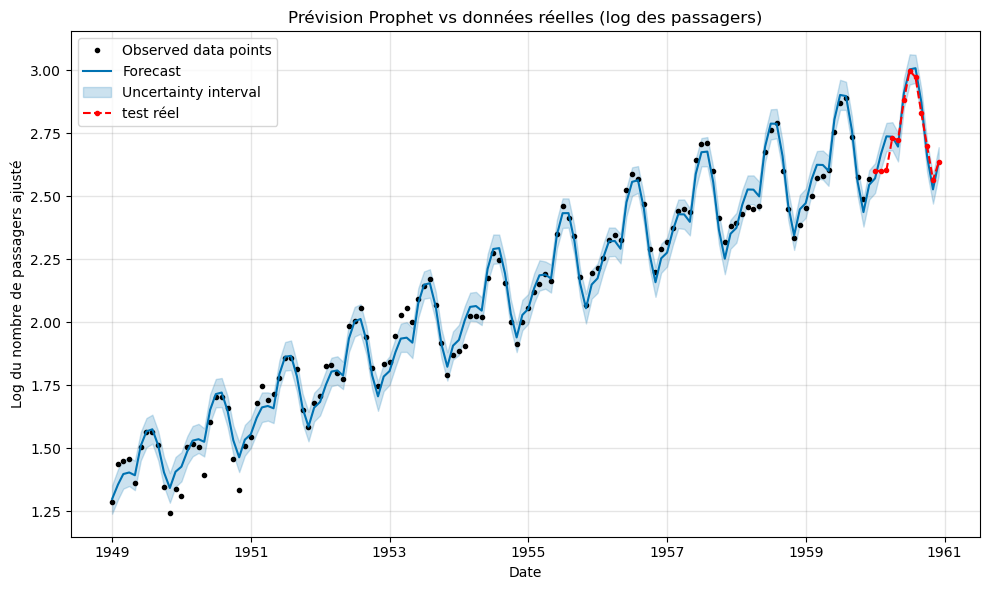

MAPE sur les données test : 1.40 %


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from pmdarima.datasets import load_airpassengers

# 1. Charger et préparer les données
START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)
airline.index = pd.date_range(START_DATE, periods=len(airline), freq='MS')
airline_adj = airline / airline.index.days_in_month

# 2. Séparer en train/test + log
train = airline_adj[airline_adj.index < '1960-01-01']
test = airline_adj[airline_adj.index >= '1960-01-01']
train_log = np.log(train)
test_log = np.log(test)

# 3. Reformatage pour Prophet
train_df = pd.DataFrame(train_log).reset_index().rename(columns={0: 'y', 'index': 'ds'})

# 4. Entraînement avec les meilleurs hyperparamètres
model = Prophet(
    changepoint_prior_scale=0.010,
    seasonality_prior_scale=10.0,
    seasonality_mode='multiplicative',
    n_changepoints=70,
    yearly_seasonality='auto'
)
model.fit(train_df)

# 5. Prédiction sur 12 mois supplémentaires
future = model.make_future_dataframe(periods=12, freq='MS', include_history=True)
forecast = model.predict(future)

# 6. Tracer
fig = model.plot(forecast)
plt.title("Prévision Prophet vs données réelles (log des passagers)")
plt.xlabel("Date")
plt.ylabel("Log du nombre de passagers ajusté")

# Ajouter les vraies valeurs de test
plt.plot(test_log.index, test_log.values, 'r.--', label='test réel')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 1. Récupérer les prédictions sur la période test
y_pred = forecast.set_index('ds').loc[test_log.index]['yhat']
y_true = test_log

# 2. Calcul MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
# MAPE sur 12 mois et non en cross validation d'ou la valeur différente
print(f"MAPE sur les données test : {mape:.2f} %")



# Optional exercise - Energy data forecasting ⚡

Forecasting energy demand is big business and very important in helping energy producers maintain the balance within the electrical grid. You can find forecasts of energy demands for France in realtime [here](https://www.rte-france.com/fr/eco2mix/eco2mix-consommation). The data was already downloaded in the `data/nats.csv` file.

Your mission now is to imagine a useful use-case for an enterprise and use `Prophet` to make forecasts on the energy data you have already seen (in data viz module) for France! Feel free to choose :
* the type of energy generation/consommation
* france or regional,
* frequency scale you wish to try!

Try and consider a forecast horizon that seems useful for the frequency at which you are making your predictions e.g. predicting the hourly forecast for 12 months propbably cannot be used in any meaningful way - and is probably not going be very easy to forecast accurately.

Consider that:
* Reducing the scale of the data, i.e. to regional
* Higher frequency predictions
* longer periods of forecast

...are likely to make it more difficult to make a good forecast.

Consider also that you must pick the most suitable cross validation procedure for your problem. Consider the initial, step and horizon you will use carefully.

Once you have made your model:
1. Compare it to a naive model!! If it does not beat this then try reducing your forecast horizon to find at what scale you can make useful predictions.
2. Try tuning the model in some way to improve performance (add holidays might be a good idea)
3. If you have time compare your model to an ARIMA model. Why might there be differences in perfomance between the two approachecs to forecasting?

(feel free to use a new notebook for this task!)

In [24]:
# On récupère les données de conso.csv
conso = pd.read_csv('conso.csv', parse_dates=['Date'], index_col='Date')
conso = conso.resample('M').mean()  # On prend la moyenne
conso = conso.dropna()  # On supprime les lignes avec des valeurs manquantes

# On trace la série temporelle
plt.figure(figsize=(12, 6))
plt.plot(conso.index, conso['Conso'], label='Consommation Électrique', color='blue')
plt.title('Consommation Électrique Mensuelle')
plt.xlabel('Date')
plt.ylabel('Consommation (kWh)')
plt.legend()
plt.grid(True)

ValueError: Missing column provided to 'parse_dates': 'Date'